[View in Colaboratory](https://colab.research.google.com/github/Naren-Jegan/Deep-Learning-Keras/blob/master/Flower_Classifier.ipynb)

In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

gpg: keybox '/tmp/tmpwjq4qglx/pubring.gpg' created
gpg: /tmp/tmpwjq4qglx/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1


In [0]:
from google.colab import auth
auth.authenticate_user()

In [3]:
# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
# Work around misordering of STREAM and STDIN in Jupyter.
# https://github.com/jupyter/notebook/issues/3159
prompt = !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass(prompt[0] + '\n\nEnter verification code: ')
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

IndexError: ignored

In [4]:
# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math
import os
from PIL import Image, ImageFilter, ImageOps, ImageMath
import random
import pickle
from time import sleep

In [0]:
# from tf.keras.models import Sequential  # This does not work!
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import InputLayer, Input
from tensorflow.python.keras.layers import Reshape, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.python.keras.layers import Conv2D, Dense, Flatten

In [27]:
tf.__version__

'1.10.1'

In [0]:
dirpath = os.path.join("drive", "Colab Notebooks")
flowerspath = os.path.join(dirpath, "flowers_resized")

shape = [128, 128, 3]
#noshape = True
f_t = {'daisy': 0, 'dandelion': 1, 'sunflower': 2, 'tulip': 3, 'rose': 4}
one_hot_encoding = dict()
no_types = 5
for i in range(no_types):
    one_hot_encoding[i] = [0]*no_types
    one_hot_encoding[i][i] = 1

def get_segmented_image(image):
  multibands = image.split()
  bands = []
  
  for i in range(len(multibands)):
    bands.append(ImageMath.eval("convert(a*b, 'L')", a = multibands[i], b = ImageOps.equalize(image).convert('L').point(lambda p : p > 16 and p < 172)))

  return Image.merge("RGB", bands)

In [0]:
data = list()
#for flower in os.listdir(flowerspath):
#    img = Image.open(os.path.join(flowerspath,flower)).convert('RGB')
#    arr = np.array(img)
#    ft = flower.split("_")[0]
#    flower_type = f_t[ft]
#    flower_type_encoded = one_hot_encoding[flower_type]
#    datum = [arr.ravel(), flower_type, flower_type_encoded]
#    data.append(datum)

In [0]:
#d = dict()
#train_data = []
#test_data = []
#for i in range(5):
#  d[i] = [x for x in data if x[1] == i]
#  n_t = int(len(d[i])*0.8)
#  train_data += d[i][0:n_t - 1]
#  test_data += d[i][n_t:]
#with open(os.path.join("drive", "Colab Notebooks", "flowerdata_256.file"), "wb") as f:
#    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)
with open(os.path.join("drive", "Colab Notebooks", "flowerdata_256.file"), "rb") as f:
    data = pickle.load(f)    

In [0]:
random.shuffle(data)
ds_len = len(data)
train_data = data[:int(0.8*ds_len)]
test_data = data[int(0.8*ds_len):int(0.9*ds_len)]
validation_data = data[int(0.9*ds_len):]
num_train = len(train_data)
num_test = len(test_data)
num_validation = len(validation_data)

In [32]:
print("training set: " + str(num_train))
print("test set: " + str(num_test))

training set: 2943
test set: 368


In [0]:
img_size = shape[0]
img_size_flat = shape[0]*shape[1]*shape[2]
img_shape = shape
img_shape_full = shape
num_classes = len(f_t)
num_channels = shape[2]

In [0]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

[[0, 1, 0, 0, 0], [0, 1, 0, 0, 0], [0, 1, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 0, 1], [0, 0, 1, 0, 0], [0, 1, 0, 0, 0], [0, 1, 0, 0, 0]]


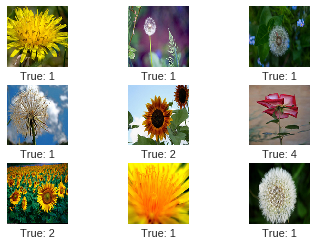

In [35]:
# Get the first images from the test-set.
images = [test_data[i][0] for i in range(9)]
# Get the true classes for those images.
cls_true = [test_data[i][1] for i in range(9)]
print([test_data[i][2] for i in range(9)])

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

In [0]:
def plot_example_errors(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Boolean array whether the predicted class is incorrect.
    incorrect = (cls_pred != data.y_test_cls)

    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.x_test[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.y_test_cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [0]:
#@title Inputs

activation = 'relu' #@param ['relu', 'softplus', 'tanh', 'sigmoid'] {type:"string"}
learning_rate = 1e-3 #@param {type:"number"}
dropout = 0.3 #@param {type:"slider", min:0.0, max:0.9, step:0.1}
n_epochs = 100 #@param {type:"slider", min:50, max:1000, step:50}
batch_size = 128 #@param {type:"slider", min:0, max:1024, step:16}
batch_size = 1 if batch_size == 0 else batch_size


In [0]:
# Start construction of the Keras Sequential model.
model = Sequential()

# Add an input layer which is similar to a feed_dict in TensorFlow.
# Note that the input-shape must be a tuple containing the image-size 256, 256, 3.
model.add(InputLayer(input_shape=(img_size_flat,)))

# The input is a flattened array,
# but the convolutional layers expect image
model.add(Reshape(img_shape_full))

# First convolutional layer with activation, batchnorm and max-pooling.
model.add(Conv2D(kernel_size=3, strides=1, filters=8, padding='same',
                 activation=activation, name='layer_conv11'))
model.add(BatchNormalization(axis = 3, name = 'bn11'))
model.add(Conv2D(kernel_size=3, strides=1, filters=8, padding='same',
                 activation=activation, name='layer_conv12'))
model.add(BatchNormalization(axis = 3, name = 'bn12'))
model.add(MaxPooling2D(pool_size=2, strides=2, name="max_pooling1"))
model.add(Dropout(dropout))

# Second convolutional layer with activation, batchnorm and max-pooling.
model.add(Conv2D(kernel_size=3, strides=1, filters=16, padding='same',
                 activation=activation, name='layer_conv21'))
model.add(BatchNormalization(axis = 3, name = 'bn21'))
model.add(Conv2D(kernel_size=3, strides=1, filters=16, padding='same',
                 activation=activation, name='layer_conv22'))
model.add(BatchNormalization(axis = 3, name = 'bn22'))
model.add(MaxPooling2D(pool_size=2, strides=2, name="max_pooling2"))
model.add(Dropout(dropout))

# Third convolutional layer with activation, batchnorm and max-pooling.
model.add(Conv2D(kernel_size=3, strides=1, filters=32, padding='same',
                 activation=activation, name='layer_conv31'))
model.add(BatchNormalization(axis = 3, name = 'bn31'))
model.add(Conv2D(kernel_size=3, strides=1, filters=32, padding='same',
                 activation=activation, name='layer_conv32'))
model.add(BatchNormalization(axis = 3, name = 'bn32'))
model.add(MaxPooling2D(pool_size=2, strides=2, name="max_pooling3"))
model.add(Dropout(dropout))

# Fourth convolutional layer with activation, batchnorm and max-pooling.
model.add(Conv2D(kernel_size=3, strides=1, filters=64, padding='same',
                 activation=activation, name='layer_conv41'))
model.add(BatchNormalization(axis = 3, name = 'bn41'))
model.add(Conv2D(kernel_size=3, strides=1, filters=64, padding='same',
                 activation=activation, name='layer_conv42'))
model.add(BatchNormalization(axis = 3, name = 'bn42'))
model.add(MaxPooling2D(pool_size=2, strides=2, name="max_pooling4"))
model.add(Dropout(dropout))

# Fifth convolutional layer with activation and max-pooling.
model.add(Conv2D(kernel_size=3, strides=1, filters=128, padding='same',
                 activation=activation, name='layer_conv51'))
model.add(BatchNormalization(axis = 3, name = 'bn51'))
model.add(Conv2D(kernel_size=3, strides=1, filters=128, padding='same',
                 activation=activation, name='layer_conv52'))
model.add(BatchNormalization(axis = 3, name = 'bn52'))
model.add(MaxPooling2D(pool_size=2, strides=2, name="max_pooling5"))
model.add(Dropout(dropout))

# Sixth convolutional layer with activation and max-pooling.
model.add(Conv2D(kernel_size=3, strides=1, filters=256, padding='same',
                 activation=activation, name='layer_conv61'))
model.add(BatchNormalization(axis = 3, name = 'bn61'))
model.add(Conv2D(kernel_size=3, strides=1, filters=256, padding='same',
                 activation=activation, name='layer_conv62'))
model.add(BatchNormalization(axis = 3, name = 'bn62'))
model.add(Conv2D(kernel_size=3, strides=1, filters=256, padding='same',
                 activation=activation, name='layer_conv63'))
model.add(BatchNormalization(axis = 3, name = 'bn63'))
model.add(MaxPooling2D(pool_size=2, strides=2, name="max_pooling6"))
model.add(Dropout(dropout))

# Seventh convolutional layer with activation and max-pooling.
model.add(Conv2D(kernel_size=3, strides=1, filters=512, padding='same',
                 activation=activation, name='layer_conv71'))
model.add(BatchNormalization(axis = 3, name = 'bn71'))
model.add(Conv2D(kernel_size=3, strides=1, filters=512, padding='same',
                 activation=activation, name='layer_conv72'))
model.add(BatchNormalization(axis = 3, name = 'bn72'))
model.add(Conv2D(kernel_size=3, strides=1, filters=512, padding='same',
                 activation=activation, name='layer_conv73'))
model.add(BatchNormalization(axis = 3, name = 'bn73'))
model.add(MaxPooling2D(pool_size=2, strides=2, name="max_pooling7"))


# Flatten the 4-rank output of the convolutional layers
# to 2-rank that can be input to a fully-connected / dense layer.
model.add(Flatten())


model.add(Dropout(dropout))
# First fully-connected / dense layer with activation.
model.add(Dense(1024, activation=activation, name = "dense_1"))
model.add(BatchNormalization(axis = 1, name = 'bn8'))


model.add(Dropout(dropout))
# Second fully-connected / dense layer with activation.
model.add(Dense(1024, activation=activation, name = "dense_2"))
model.add(BatchNormalization(axis = 1, name = 'bn9'))

model.add(Dense(num_classes, activation='softmax', name = "dense_3"))

In [0]:
from tensorflow.python.keras.optimizers import Adam
#from tensorflow.python.keras.optimizers import SGD

optimizer = Adam(lr=learning_rate)
#optimizer = SGD(lr=learning_rate)

In [0]:
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [21]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=0.0001)

Using TensorFlow backend.


In [22]:
model.fit(x=np.array([td[0]/255 for td in train_data]),
          y=np.array([td[2] for td in train_data]),
          batch_size=batch_size, shuffle = True,
          epochs=n_epochs,
          validation_data = (np.array([td[0]/255 for td in validation_data]), np.array([td[2] for td in validation_data]))#,
          #callbacks=[early_stopping]
         )
#min validation loss so far: 0.8
#max validation accuracy so far: 79%

Train on 2943 samples, validate on 368 samples
Epoch 1/100
2943/2943 [==============================] - 16s 6ms/step - loss: 2.1280 - acc: 0.2650 - val_loss: 1.6163 - val_acc: 0.2228
Epoch 2/100
2943/2943 [==============================] - 7s 2ms/step - loss: 1.7612 - acc: 0.3391 - val_loss: 1.8123 - val_acc: 0.1875
Epoch 3/100
2943/2943 [==============================] - 7s 2ms/step - loss: 1.4692 - acc: 0.4057 - val_loss: 1.8692 - val_acc: 0.2228
Epoch 4/100
2943/2943 [==============================] - 7s 2ms/step - loss: 1.3394 - acc: 0.4557 - val_loss: 2.9109 - val_acc: 0.2228
Epoch 5/100
2943/2943 [==============================] - 7s 2ms/step - loss: 1.2533 - acc: 0.4856 - val_loss: 2.9682 - val_acc: 0.2228
Epoch 6/100
2943/2943 [==============================] - 7s 2ms/step - loss: 1.2024 - acc: 0.5090 - val_loss: 2.4687 - val_acc: 0.2228
Epoch 7/100
2943/2943 [==============================] - 7s 2ms/step - loss: 1.1460 - acc: 0.5270 - val_loss: 3.1696 - val_acc: 0.2228
Epoch 8

In [23]:
result = model.evaluate(x=np.array([td[0] for td in test_data]),
                        y=np.array([td[2] for td in test_data]))

368/368 [==============================] - 0s 1ms/step


In [24]:
for name, value in zip(model.metrics_names, result):
    print(name, value)
print("{0}: {1:.2%}".format(model.metrics_names[1], result[1]))

loss 12.828712048737898
acc 0.1983695652173913
acc: 19.84%


[[8.49497330e-04 3.78643454e-05 9.76850186e-03 9.88525748e-01
  8.18424334e-04]
 [2.64378526e-04 9.99491811e-01 1.18413984e-04 9.26746943e-05
  3.26299378e-05]
 [1.41706725e-03 3.69388508e-05 4.74129192e-04 9.97661114e-01
  4.10667562e-04]
 [3.99051023e-05 4.92731897e-06 9.80489016e-01 1.13267940e-03
  1.83333643e-02]
 [1.36249736e-02 7.36834994e-03 4.36095666e-04 5.45432448e-01
  4.33138102e-01]
 [9.91742134e-01 7.75819970e-03 1.29405656e-04 2.02253999e-04
  1.68070212e-04]
 [1.83687138e-03 1.31449095e-04 9.77526188e-01 6.16657082e-03
  1.43389162e-02]
 [7.03515708e-01 6.54142816e-03 2.78912503e-05 4.48226550e-04
  2.89466739e-01]
 [8.46286493e-05 1.09094437e-02 9.88963962e-01 3.38354002e-05
  8.13457973e-06]]


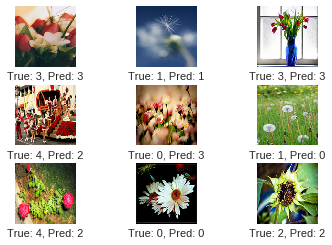

In [25]:
# Get the first images from the test-set.
images = np.array([test_data[i][0]/255 for i in range(18,27)])
# Get the true classes for those images.
cls_true = np.array([test_data[i][1] for i in range(18,27)])

y_pred = model.predict(x=images)
print(y_pred)
cls_pred = [x for x in np.argmax(y_pred, axis=1)]

plot_images(images=images,
            cls_true=cls_true,
            cls_pred=cls_pred)